In [1]:
import os
import numpy as np
import nibabel as nib
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob


In [2]:
BASE_PATH = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"
SAVE_PATH = "/kaggle/working/preprocessed_cgan"
os.makedirs(SAVE_PATH, exist_ok=True)

MODALITIES = {
    "t1n": "t1n.nii",
    "t1c": "t1c.nii",
    "t2w": "t2w.nii",
    "t2f": "t2f.nii",
    "seg": "seg.nii"
}

IMG_SIZE = 256
SLICES_PER_PATIENT = 20


In [3]:
def preprocess_slice(img, size=IMG_SIZE):
    img = np.nan_to_num(img)
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    return cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)

patients = sorted(glob(os.path.join(BASE_PATH, "*")))
print("Found", len(patients), "patients")

for patient in tqdm(patients[:50]):  # reduce if needed
    pid = os.path.basename(patient)
    volumes = {}

    for mod, suffix in MODALITIES.items():
        path = glob(os.path.join(patient, f"*{suffix}"))[0]
        volumes[mod] = nib.load(path).get_fdata()

    center = volumes["t1n"].shape[2] // 2
    z_range = range(center - SLICES_PER_PATIENT//2, center + SLICES_PER_PATIENT//2)

    for z in z_range:
        for mod in MODALITIES:
            img = preprocess_slice(volumes[mod][:, :, z])
            np.save(os.path.join(SAVE_PATH, f"{pid}_z{z}_{mod}.npy"), img)


Found 200 patients


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


In [4]:
class BraTSCGANDataset(Dataset):
    def __init__(self, path, input_mods, target_mods):
        self.path = path
        self.input_mods = input_mods
        self.target_mods = target_mods

        self.ids = sorted([
            f.replace(f"_{input_mods[0]}.npy", "")
            for f in os.listdir(path) if f.endswith(f"_{input_mods[0]}.npy")
        ])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        base = self.ids[idx]
        inputs = [np.load(os.path.join(self.path, f"{base}_{mod}.npy")) for mod in self.input_mods]
        targets = [np.load(os.path.join(self.path, f"{base}_{mod}.npy")) for mod in self.target_mods]

        x = torch.tensor(np.stack(inputs), dtype=torch.float32)
        y = torch.tensor(np.stack(targets), dtype=torch.float32)
        return x, y


In [5]:
input_mods = ["t1n", "t1c", "t2w"]
target_mods = ["t2f", "seg"]

dataset = BraTSCGANDataset(SAVE_PATH, input_mods, target_mods)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

x, y = next(iter(dataloader))
print("Inputs:", x.shape, "| Targets:", y.shape)


Inputs: torch.Size([4, 3, 256, 256]) | Targets: torch.Size([4, 2, 256, 256])


In [6]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super().__init__()

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 4, stride=2, padding=1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )

        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, 4, stride=2, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.down1 = block(in_channels, 64)
        self.down2 = block(64, 128)
        self.down3 = block(128, 256)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.ReLU()
        )

        self.up3 = up_block(512, 256)
        self.up2 = up_block(256 * 2, 128)
        self.up1 = up_block(128 * 2, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(64 * 2, out_channels, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        b = self.bottleneck(d3)
        u3 = self.up3(b)
        u2 = self.up2(torch.cat([u3, d3], dim=1))
        u1 = self.up1(torch.cat([u2, d2], dim=1))
        return self.final(torch.cat([u1, d1], dim=1))


In [7]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3 + 2):  # input + target
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        inp = torch.cat([x, y], dim=1)
        return self.model(inp)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = GeneratorUNet().to(device)
discriminator = PatchDiscriminator().to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

bce = nn.BCELoss()
l1 = nn.L1Loss()
lambda_l1 = 100  # weight for L1 loss

def train_step(x, y):
    x, y = x.to(device), y.to(device)

    # Generate fake outputs from generator
    fake_y = generator(x)

    # Get discriminator output shapes
    d_real_out = discriminator(x, y)
    d_fake_out = discriminator(x, fake_y.detach())  # detach to avoid backprop to generator

    # Dynamic label tensors based on discriminator output shape
    real_label = torch.ones_like(d_real_out, device=device)
    fake_label = torch.zeros_like(d_fake_out, device=device)

    # Discriminator loss
    d_loss_real = bce(d_real_out, real_label)
    d_loss_fake = bce(d_fake_out, fake_label)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)

    discriminator.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # Generator loss
    fake_y = generator(x)  # forward again for gradients
    d_fake_for_g = discriminator(x, fake_y)
    adv_loss = bce(d_fake_for_g, real_label)  # try to fool discriminator
    l1_loss_val = l1(fake_y, y)
    g_loss = adv_loss + lambda_l1 * l1_loss_val

    generator.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    return d_loss.item(), g_loss.item(), l1_loss_val.item()

In [9]:
EPOCHS = 100
losses_g, losses_d, l1s = [], [], []

for epoch in range(1, EPOCHS + 1):
    g_epoch_loss, d_epoch_loss, l1_epoch = 0, 0, 0
    for x, y in tqdm(dataloader, desc=f"Epoch {epoch}/{EPOCHS}"):
        d_loss, g_loss, l1_loss_val = train_step(x, y)
        d_epoch_loss += d_loss
        g_epoch_loss += g_loss
        l1_epoch += l1_loss_val

    print(f"Epoch {epoch} | D: {d_epoch_loss:.4f} | G: {g_epoch_loss:.4f} | L1: {l1_epoch:.4f}")
    losses_d.append(d_epoch_loss)
    losses_g.append(g_epoch_loss)
    l1s.append(l1_epoch)


Epoch 1/100: 100%|██████████| 250/250 [00:21<00:00, 11.69it/s]


Epoch 1 | D: 113.9292 | G: 2994.5045 | L1: 26.9694


Epoch 2/100: 100%|██████████| 250/250 [00:20<00:00, 12.20it/s]


Epoch 2 | D: 135.6614 | G: 1123.7787 | L1: 8.6667


Epoch 3/100: 100%|██████████| 250/250 [00:21<00:00, 11.89it/s]


Epoch 3 | D: 150.5619 | G: 915.1511 | L1: 6.9216


Epoch 4/100: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 4 | D: 157.9128 | G: 817.9698 | L1: 6.1105


Epoch 5/100: 100%|██████████| 250/250 [00:22<00:00, 11.07it/s]


Epoch 5 | D: 162.3966 | G: 744.8009 | L1: 5.4658


Epoch 6/100: 100%|██████████| 250/250 [00:22<00:00, 11.22it/s]


Epoch 6 | D: 165.7780 | G: 673.1822 | L1: 4.8116


Epoch 7/100: 100%|██████████| 250/250 [00:21<00:00, 11.40it/s]


Epoch 7 | D: 167.8727 | G: 629.7451 | L1: 4.4144


Epoch 8/100: 100%|██████████| 250/250 [00:21<00:00, 11.38it/s]


Epoch 8 | D: 168.5279 | G: 594.4447 | L1: 4.0806


Epoch 9/100: 100%|██████████| 250/250 [00:22<00:00, 11.29it/s]


Epoch 9 | D: 169.0332 | G: 559.8222 | L1: 3.7494


Epoch 10/100: 100%|██████████| 250/250 [00:22<00:00, 11.32it/s]


Epoch 10 | D: 169.5388 | G: 535.7813 | L1: 3.5160


Epoch 11/100: 100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Epoch 11 | D: 169.9438 | G: 515.6130 | L1: 3.3278


Epoch 12/100: 100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Epoch 12 | D: 170.3064 | G: 500.5688 | L1: 3.1818


Epoch 13/100: 100%|██████████| 250/250 [00:21<00:00, 11.38it/s]


Epoch 13 | D: 170.3187 | G: 485.9066 | L1: 3.0410


Epoch 14/100: 100%|██████████| 250/250 [00:21<00:00, 11.37it/s]


Epoch 14 | D: 170.3804 | G: 474.6237 | L1: 2.9321


Epoch 15/100: 100%|██████████| 250/250 [00:22<00:00, 11.35it/s]


Epoch 15 | D: 170.7918 | G: 464.3286 | L1: 2.8317


Epoch 16/100: 100%|██████████| 250/250 [00:21<00:00, 11.37it/s]


Epoch 16 | D: 170.9106 | G: 456.5132 | L1: 2.7592


Epoch 17/100: 100%|██████████| 250/250 [00:22<00:00, 11.36it/s]


Epoch 17 | D: 170.4394 | G: 446.8100 | L1: 2.6602


Epoch 18/100: 100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Epoch 18 | D: 170.7930 | G: 440.0828 | L1: 2.5974


Epoch 19/100: 100%|██████████| 250/250 [00:22<00:00, 11.35it/s]


Epoch 19 | D: 170.8760 | G: 434.7704 | L1: 2.5435


Epoch 20/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 20 | D: 170.8723 | G: 427.6507 | L1: 2.4772


Epoch 21/100: 100%|██████████| 250/250 [00:22<00:00, 11.33it/s]


Epoch 21 | D: 170.8149 | G: 421.8195 | L1: 2.4182


Epoch 22/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 22 | D: 171.1189 | G: 416.7760 | L1: 2.3695


Epoch 23/100: 100%|██████████| 250/250 [00:22<00:00, 11.30it/s]


Epoch 23 | D: 171.3738 | G: 413.5948 | L1: 2.3470


Epoch 24/100: 100%|██████████| 250/250 [00:22<00:00, 11.30it/s]


Epoch 24 | D: 171.4987 | G: 406.9281 | L1: 2.2801


Epoch 25/100: 100%|██████████| 250/250 [00:22<00:00, 11.32it/s]


Epoch 25 | D: 171.6020 | G: 399.8093 | L1: 2.2116


Epoch 26/100: 100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Epoch 26 | D: 171.5634 | G: 398.2449 | L1: 2.1976


Epoch 27/100: 100%|██████████| 250/250 [00:22<00:00, 11.33it/s]


Epoch 27 | D: 171.7223 | G: 396.6647 | L1: 2.1817


Epoch 28/100: 100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Epoch 28 | D: 171.7469 | G: 390.5337 | L1: 2.1239


Epoch 29/100: 100%|██████████| 250/250 [00:22<00:00, 11.35it/s]


Epoch 29 | D: 171.8327 | G: 387.1228 | L1: 2.0930


Epoch 30/100: 100%|██████████| 250/250 [00:22<00:00, 11.36it/s]


Epoch 30 | D: 171.8427 | G: 388.4328 | L1: 2.1061


Epoch 31/100: 100%|██████████| 250/250 [00:22<00:00, 11.35it/s]


Epoch 31 | D: 171.7771 | G: 381.6329 | L1: 2.0398


Epoch 32/100: 100%|██████████| 250/250 [00:21<00:00, 11.37it/s]


Epoch 32 | D: 171.9515 | G: 378.1652 | L1: 2.0040


Epoch 33/100: 100%|██████████| 250/250 [00:21<00:00, 11.36it/s]


Epoch 33 | D: 172.0363 | G: 374.8342 | L1: 1.9717


Epoch 34/100: 100%|██████████| 250/250 [00:22<00:00, 11.36it/s]


Epoch 34 | D: 171.8929 | G: 375.2183 | L1: 1.9792


Epoch 35/100: 100%|██████████| 250/250 [00:21<00:00, 11.37it/s]


Epoch 35 | D: 172.0520 | G: 370.8705 | L1: 1.9375


Epoch 36/100: 100%|██████████| 250/250 [00:21<00:00, 11.37it/s]


Epoch 36 | D: 171.8706 | G: 369.0801 | L1: 1.9198


Epoch 37/100: 100%|██████████| 250/250 [00:22<00:00, 11.35it/s]


Epoch 37 | D: 172.0779 | G: 366.0735 | L1: 1.8905


Epoch 38/100: 100%|██████████| 250/250 [00:22<00:00, 11.33it/s]


Epoch 38 | D: 172.0366 | G: 365.2048 | L1: 1.8816


Epoch 39/100: 100%|██████████| 250/250 [00:22<00:00, 11.33it/s]


Epoch 39 | D: 172.0872 | G: 361.3662 | L1: 1.8433


Epoch 40/100: 100%|██████████| 250/250 [00:22<00:00, 11.32it/s]


Epoch 40 | D: 171.9872 | G: 358.8353 | L1: 1.8195


Epoch 41/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 41 | D: 172.1464 | G: 359.1710 | L1: 1.8235


Epoch 42/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 42 | D: 172.0056 | G: 356.2808 | L1: 1.7939


Epoch 43/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 43 | D: 172.0425 | G: 355.8894 | L1: 1.7924


Epoch 44/100: 100%|██████████| 250/250 [00:22<00:00, 11.30it/s]


Epoch 44 | D: 172.1205 | G: 352.8675 | L1: 1.7617


Epoch 45/100: 100%|██████████| 250/250 [00:22<00:00, 11.30it/s]


Epoch 45 | D: 172.0970 | G: 349.5695 | L1: 1.7296


Epoch 46/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 46 | D: 172.1457 | G: 349.7476 | L1: 1.7307


Epoch 47/100: 100%|██████████| 250/250 [00:22<00:00, 11.30it/s]


Epoch 47 | D: 172.0459 | G: 348.7485 | L1: 1.7231


Epoch 48/100: 100%|██████████| 250/250 [00:22<00:00, 11.30it/s]


Epoch 48 | D: 172.1802 | G: 349.4257 | L1: 1.7276


Epoch 49/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 49 | D: 172.2590 | G: 345.3435 | L1: 1.6879


Epoch 50/100: 100%|██████████| 250/250 [00:22<00:00, 11.30it/s]


Epoch 50 | D: 172.1290 | G: 345.7591 | L1: 1.6931


Epoch 51/100: 100%|██████████| 250/250 [00:22<00:00, 11.30it/s]


Epoch 51 | D: 172.0683 | G: 341.0977 | L1: 1.6464


Epoch 52/100: 100%|██████████| 250/250 [00:22<00:00, 11.33it/s]


Epoch 52 | D: 172.1283 | G: 339.6114 | L1: 1.6314


Epoch 53/100: 100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Epoch 53 | D: 172.1679 | G: 339.4642 | L1: 1.6308


Epoch 54/100: 100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Epoch 54 | D: 172.2148 | G: 341.3323 | L1: 1.6493


Epoch 55/100: 100%|██████████| 250/250 [00:22<00:00, 11.35it/s]


Epoch 55 | D: 172.1264 | G: 337.5193 | L1: 1.6114


Epoch 56/100: 100%|██████████| 250/250 [00:22<00:00, 11.36it/s]


Epoch 56 | D: 172.1941 | G: 339.4570 | L1: 1.6313


Epoch 57/100: 100%|██████████| 250/250 [00:22<00:00, 11.36it/s]


Epoch 57 | D: 172.1394 | G: 335.9334 | L1: 1.5970


Epoch 58/100: 100%|██████████| 250/250 [00:22<00:00, 11.36it/s]


Epoch 58 | D: 172.1537 | G: 335.1293 | L1: 1.5881


Epoch 59/100: 100%|██████████| 250/250 [00:21<00:00, 11.38it/s]


Epoch 59 | D: 172.1507 | G: 333.8254 | L1: 1.5747


Epoch 60/100: 100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Epoch 60 | D: 172.1317 | G: 333.2737 | L1: 1.5687


Epoch 61/100: 100%|██████████| 250/250 [00:22<00:00, 11.36it/s]


Epoch 61 | D: 172.0789 | G: 331.1577 | L1: 1.5464


Epoch 62/100: 100%|██████████| 250/250 [00:22<00:00, 11.36it/s]


Epoch 62 | D: 172.1495 | G: 331.4757 | L1: 1.5524


Epoch 63/100: 100%|██████████| 250/250 [00:22<00:00, 11.36it/s]


Epoch 63 | D: 172.0952 | G: 331.8847 | L1: 1.5555


Epoch 64/100: 100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Epoch 64 | D: 172.1220 | G: 331.9941 | L1: 1.5546


Epoch 65/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 65 | D: 172.1280 | G: 329.2447 | L1: 1.5283


Epoch 66/100: 100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Epoch 66 | D: 172.0343 | G: 328.3249 | L1: 1.5191


Epoch 67/100: 100%|██████████| 250/250 [00:22<00:00, 11.32it/s]


Epoch 67 | D: 172.1012 | G: 327.2940 | L1: 1.5088


Epoch 68/100: 100%|██████████| 250/250 [00:22<00:00, 11.32it/s]


Epoch 68 | D: 172.0110 | G: 327.2226 | L1: 1.5077


Epoch 69/100: 100%|██████████| 250/250 [00:22<00:00, 11.32it/s]


Epoch 69 | D: 172.1612 | G: 326.9770 | L1: 1.5058


Epoch 70/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 70 | D: 172.0466 | G: 325.0214 | L1: 1.4869


Epoch 71/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 71 | D: 172.1065 | G: 325.1453 | L1: 1.4855


Epoch 72/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 72 | D: 172.1768 | G: 323.0018 | L1: 1.4662


Epoch 73/100: 100%|██████████| 250/250 [00:22<00:00, 11.33it/s]


Epoch 73 | D: 172.1471 | G: 323.8080 | L1: 1.4738


Epoch 74/100: 100%|██████████| 250/250 [00:22<00:00, 11.29it/s]


Epoch 74 | D: 172.0991 | G: 322.1111 | L1: 1.4591


Epoch 75/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 75 | D: 172.1979 | G: 322.3388 | L1: 1.4602


Epoch 76/100: 100%|██████████| 250/250 [00:22<00:00, 11.32it/s]


Epoch 76 | D: 172.1343 | G: 321.0214 | L1: 1.4472


Epoch 77/100: 100%|██████████| 250/250 [00:22<00:00, 11.30it/s]


Epoch 77 | D: 172.1802 | G: 319.7332 | L1: 1.4343


Epoch 78/100: 100%|██████████| 250/250 [00:22<00:00, 11.30it/s]


Epoch 78 | D: 172.3056 | G: 319.9712 | L1: 1.4373


Epoch 79/100: 100%|██████████| 250/250 [00:22<00:00, 11.32it/s]


Epoch 79 | D: 174.7311 | G: 319.6039 | L1: 1.4178


Epoch 80/100: 100%|██████████| 250/250 [00:22<00:00, 11.33it/s]


Epoch 80 | D: 171.8027 | G: 315.2172 | L1: 1.3909


Epoch 81/100: 100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Epoch 81 | D: 171.8612 | G: 316.6562 | L1: 1.4077


Epoch 82/100: 100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Epoch 82 | D: 172.1122 | G: 317.2238 | L1: 1.4148


Epoch 83/100: 100%|██████████| 250/250 [00:22<00:00, 11.36it/s]


Epoch 83 | D: 172.2786 | G: 315.6816 | L1: 1.4005


Epoch 84/100: 100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Epoch 84 | D: 172.3844 | G: 314.3365 | L1: 1.3857


Epoch 85/100: 100%|██████████| 250/250 [00:22<00:00, 11.36it/s]


Epoch 85 | D: 172.3802 | G: 315.0721 | L1: 1.3949


Epoch 86/100: 100%|██████████| 250/250 [00:22<00:00, 11.36it/s]


Epoch 86 | D: 172.4027 | G: 316.6615 | L1: 1.4097


Epoch 87/100: 100%|██████████| 250/250 [00:22<00:00, 11.36it/s]


Epoch 87 | D: 172.4842 | G: 314.2588 | L1: 1.3854


Epoch 88/100: 100%|██████████| 250/250 [00:22<00:00, 11.29it/s]


Epoch 88 | D: 172.4018 | G: 313.8560 | L1: 1.3822


Epoch 89/100: 100%|██████████| 250/250 [00:22<00:00, 11.33it/s]


Epoch 89 | D: 172.5313 | G: 312.0710 | L1: 1.3623


Epoch 90/100: 100%|██████████| 250/250 [00:22<00:00, 11.32it/s]


Epoch 90 | D: 172.4298 | G: 312.0997 | L1: 1.3646


Epoch 91/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 91 | D: 172.4742 | G: 311.7840 | L1: 1.3603


Epoch 92/100: 100%|██████████| 250/250 [00:22<00:00, 11.30it/s]


Epoch 92 | D: 172.4336 | G: 310.8706 | L1: 1.3519


Epoch 93/100: 100%|██████████| 250/250 [00:22<00:00, 11.32it/s]


Epoch 93 | D: 172.5088 | G: 310.1875 | L1: 1.3445


Epoch 94/100: 100%|██████████| 250/250 [00:22<00:00, 11.30it/s]


Epoch 94 | D: 172.4972 | G: 310.0053 | L1: 1.3434


Epoch 95/100: 100%|██████████| 250/250 [00:22<00:00, 11.33it/s]


Epoch 95 | D: 172.4445 | G: 308.8836 | L1: 1.3322


Epoch 96/100: 100%|██████████| 250/250 [00:22<00:00, 11.32it/s]


Epoch 96 | D: 172.6583 | G: 309.9191 | L1: 1.3407


Epoch 97/100: 100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Epoch 97 | D: 172.3889 | G: 309.9089 | L1: 1.3428


Epoch 98/100: 100%|██████████| 250/250 [00:22<00:00, 11.32it/s]


Epoch 98 | D: 172.8394 | G: 309.5928 | L1: 1.3372


Epoch 99/100: 100%|██████████| 250/250 [00:22<00:00, 11.33it/s]


Epoch 99 | D: 172.3906 | G: 306.6033 | L1: 1.3105


Epoch 100/100: 100%|██████████| 250/250 [00:22<00:00, 11.33it/s]

Epoch 100 | D: 172.5404 | G: 310.1160 | L1: 1.3464


In [10]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

def evaluate(generator, dataloader):
    generator.eval()
    ssim_total, psnr_total = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            preds = generator(x).cpu().numpy()
            targets = y.numpy()

            preds = np.clip(preds, 0, 1)
            targets = np.clip(targets, 0, 1)

            for i in range(preds.shape[0]):
                psnr_total.append(peak_signal_noise_ratio(targets[i][0], preds[i][0], data_range=1.0))
                ssim_total.append(structural_similarity(targets[i][0], preds[i][0], data_range=1.0))

    return np.mean(ssim_total), np.mean(psnr_total)

# Run this after training
ssim_val, psnr_val = evaluate(generator, dataloader)
print(f"✅ SSIM (T2f): {ssim_val:.4f}")
print(f"✅ PSNR (T2f): {psnr_val:.4f}")


✅ SSIM (T2f): 0.9569
✅ PSNR (T2f): 35.5748


In [11]:
start_epoch = 101
end_epoch = 150

for epoch in range(start_epoch, end_epoch + 1):
    g_epoch_loss, d_epoch_loss, l1_epoch = 0, 0, 0
    for x, y in tqdm(dataloader, desc=f"Epoch {epoch}/{end_epoch}"):
        d_loss, g_loss, l1_loss_val = train_step(x, y)
        d_epoch_loss += d_loss
        g_epoch_loss += g_loss
        l1_epoch += l1_loss_val

    print(f"Epoch {epoch} | D: {d_epoch_loss:.4f} | G: {g_epoch_loss:.4f} | L1: {l1_epoch:.4f}")
    losses_d.append(d_epoch_loss)
    losses_g.append(g_epoch_loss)
    l1s.append(l1_epoch)

    # Save checkpoint every 10 epochs
    if epoch % 10 == 0:
        torch.save(generator.state_dict(), f"cgan_t2f_seg_epoch{epoch}.pth")


Epoch 101/150: 100%|██████████| 250/250 [00:21<00:00, 11.39it/s]


Epoch 101 | D: 172.8005 | G: 347.7478 | L1: 1.7167


Epoch 102/150: 100%|██████████| 250/250 [00:22<00:00, 11.15it/s]


Epoch 102 | D: 172.5167 | G: 312.0998 | L1: 1.3676


Epoch 103/150: 100%|██████████| 250/250 [00:21<00:00, 11.51it/s]


Epoch 103 | D: 172.4584 | G: 307.2518 | L1: 1.3190


Epoch 104/150: 100%|██████████| 250/250 [00:21<00:00, 11.60it/s]


Epoch 104 | D: 172.5784 | G: 306.5410 | L1: 1.3110


Epoch 105/150: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 105 | D: 172.5088 | G: 303.4252 | L1: 1.2799


Epoch 106/150: 100%|██████████| 250/250 [00:21<00:00, 11.41it/s]


Epoch 106 | D: 172.5952 | G: 303.6372 | L1: 1.2819


Epoch 107/150: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 107 | D: 172.5245 | G: 302.7156 | L1: 1.2731


Epoch 108/150: 100%|██████████| 250/250 [00:21<00:00, 11.50it/s]


Epoch 108 | D: 174.9064 | G: 306.5682 | L1: 1.2930


Epoch 109/150: 100%|██████████| 250/250 [00:21<00:00, 11.49it/s]


Epoch 109 | D: 173.0502 | G: 298.0962 | L1: 1.2351


Epoch 110/150: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 110 | D: 172.1707 | G: 299.6452 | L1: 1.2373


Epoch 111/150: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 111 | D: 172.1113 | G: 299.2757 | L1: 1.2339


Epoch 112/150: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 112 | D: 172.4259 | G: 303.1184 | L1: 1.2773


Epoch 113/150: 100%|██████████| 250/250 [00:21<00:00, 11.43it/s]


Epoch 113 | D: 172.4380 | G: 299.7029 | L1: 1.2440


Epoch 114/150: 100%|██████████| 250/250 [00:21<00:00, 11.43it/s]


Epoch 114 | D: 172.5621 | G: 299.3559 | L1: 1.2414


Epoch 115/150: 100%|██████████| 250/250 [00:21<00:00, 11.42it/s]


Epoch 115 | D: 172.5550 | G: 299.1968 | L1: 1.2399


Epoch 116/150: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 116 | D: 172.5855 | G: 300.6333 | L1: 1.2546


Epoch 117/150: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 117 | D: 172.6316 | G: 299.4830 | L1: 1.2430


Epoch 118/150: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 118 | D: 172.7054 | G: 298.7612 | L1: 1.2346


Epoch 119/150: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 119 | D: 172.7128 | G: 298.1696 | L1: 1.2276


Epoch 120/150: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 120 | D: 172.7769 | G: 297.8173 | L1: 1.2264


Epoch 121/150: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 121 | D: 172.5727 | G: 298.2993 | L1: 1.2319


Epoch 122/150: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 122 | D: 172.6208 | G: 295.7277 | L1: 1.2059


Epoch 123/150: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 123 | D: 172.5992 | G: 295.7186 | L1: 1.2054


Epoch 124/150: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 124 | D: 172.6914 | G: 296.7067 | L1: 1.2146


Epoch 125/150: 100%|██████████| 250/250 [00:21<00:00, 11.49it/s]


Epoch 125 | D: 172.6540 | G: 298.9972 | L1: 1.2379


Epoch 126/150: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 126 | D: 174.3616 | G: 294.5720 | L1: 1.1880


Epoch 127/150: 100%|██████████| 250/250 [00:21<00:00, 11.50it/s]


Epoch 127 | D: 171.9873 | G: 292.7330 | L1: 1.1681


Epoch 128/150: 100%|██████████| 250/250 [00:21<00:00, 11.49it/s]


Epoch 128 | D: 172.2915 | G: 294.7294 | L1: 1.1951


Epoch 129/150: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 129 | D: 172.5285 | G: 294.1937 | L1: 1.1905


Epoch 130/150: 100%|██████████| 250/250 [00:21<00:00, 11.50it/s]


Epoch 130 | D: 172.6161 | G: 293.8286 | L1: 1.1870


Epoch 131/150: 100%|██████████| 250/250 [00:21<00:00, 11.49it/s]


Epoch 131 | D: 172.6165 | G: 292.8796 | L1: 1.1784


Epoch 132/150: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 132 | D: 172.6274 | G: 296.0540 | L1: 1.2107


Epoch 133/150: 100%|██████████| 250/250 [00:21<00:00, 11.49it/s]


Epoch 133 | D: 172.6709 | G: 292.1136 | L1: 1.1707


Epoch 134/150: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 134 | D: 172.6438 | G: 293.3016 | L1: 1.1819


Epoch 135/150: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 135 | D: 172.7008 | G: 290.3686 | L1: 1.1512


Epoch 136/150: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 136 | D: 172.7590 | G: 292.9592 | L1: 1.1761


Epoch 137/150: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 137 | D: 172.6692 | G: 293.2386 | L1: 1.1809


Epoch 138/150: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 138 | D: 172.7285 | G: 293.1052 | L1: 1.1794


Epoch 139/150: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 139 | D: 172.6323 | G: 291.6422 | L1: 1.1658


Epoch 140/150: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 140 | D: 172.6644 | G: 290.7099 | L1: 1.1566


Epoch 141/150: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 141 | D: 174.1338 | G: 292.5517 | L1: 1.1656


Epoch 142/150: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 142 | D: 173.0399 | G: 286.8817 | L1: 1.1253


Epoch 143/150: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 143 | D: 172.0310 | G: 288.8153 | L1: 1.1316


Epoch 144/150: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 144 | D: 172.0685 | G: 290.2207 | L1: 1.1475


Epoch 145/150: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 145 | D: 172.5614 | G: 291.9421 | L1: 1.1662


Epoch 146/150: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 146 | D: 172.5073 | G: 287.9991 | L1: 1.1279


Epoch 147/150: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 147 | D: 172.8460 | G: 287.9615 | L1: 1.1235


Epoch 148/150: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 148 | D: 173.2000 | G: 289.3855 | L1: 1.1346


Epoch 149/150: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 149 | D: 166.2387 | G: 304.3536 | L1: 1.1702


Epoch 150/150: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 150 | D: 162.6212 | G: 315.0909 | L1: 1.2008


In [12]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

def evaluate(generator, dataloader):
    generator.eval()
    ssim_total, psnr_total = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            preds = generator(x).cpu().numpy()
            targets = y.numpy()

            preds = np.clip(preds, 0, 1)
            targets = np.clip(targets, 0, 1)

            for i in range(preds.shape[0]):
                psnr_total.append(peak_signal_noise_ratio(targets[i][0], preds[i][0], data_range=1.0))
                ssim_total.append(structural_similarity(targets[i][0], preds[i][0], data_range=1.0))

    return np.mean(ssim_total), np.mean(psnr_total)

# Run this after training
ssim_val, psnr_val = evaluate(generator, dataloader)
print(f"✅ SSIM (T2f): {ssim_val:.4f}")
print(f"✅ PSNR (T2f): {psnr_val:.4f}")


✅ SSIM (T2f): 0.9626
✅ PSNR (T2f): 36.2099


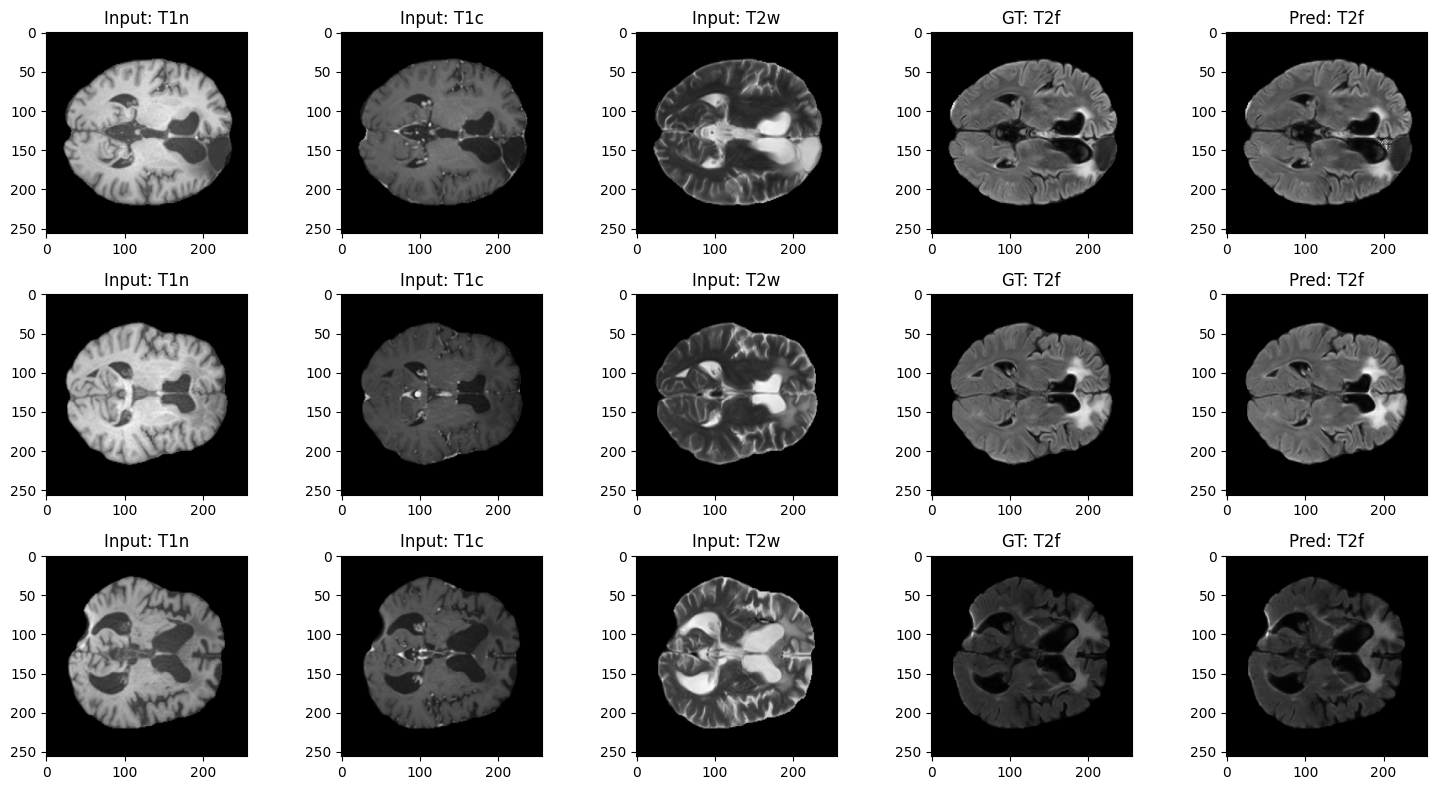

In [13]:
def visualize_samples(generator, dataloader):
    generator.eval()
    x, y = next(iter(dataloader))
    x = x.to(device)
    with torch.no_grad():
        preds = generator(x).cpu().numpy()
    x = x.cpu().numpy()
    y = y.cpu().numpy()

    plt.figure(figsize=(15, 8))
    for i in range(3):
        plt.subplot(3, 5, i*5 + 1)
        plt.imshow(x[i][0], cmap='gray')
        plt.title("Input: T1n")

        plt.subplot(3, 5, i*5 + 2)
        plt.imshow(x[i][1], cmap='gray')
        plt.title("Input: T1c")

        plt.subplot(3, 5, i*5 + 3)
        plt.imshow(x[i][2], cmap='gray')
        plt.title("Input: T2w")

        plt.subplot(3, 5, i*5 + 4)
        plt.imshow(y[i][0], cmap='gray')
        plt.title("GT: T2f")

        plt.subplot(3, 5, i*5 + 5)
        plt.imshow(preds[i][0], cmap='gray')
        plt.title("Pred: T2f")

    plt.tight_layout()
    plt.show()

visualize_samples(generator, dataloader)


In [14]:
torch.save({
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
}, "cgan_models_t2f_seg_150.pth")

print("✅ Both Generator and Discriminator saved!")


✅ Both Generator and Discriminator saved!


In [15]:
with open("cgan_model_arch_150.txt", "w") as f:
    f.write(str(generator))

## BEYOND 150 EPOCHS

In [16]:
checkpoint = torch.load("/kaggle/input/brats_unet_cgan_epoch150.pth/other/default/1/cgan_models_t2f_seg_150.pth", map_location=device)

generator.load_state_dict(checkpoint['generator'])
discriminator.load_state_dict(checkpoint['discriminator'])

print("✅ Generator and Discriminator loaded from epoch 150 checkpoint")


<ipython-input-16-e63de65db896>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/brats_unet_cgan_epoch150.pth/other/default/1/cgan_mod

✅ Generator and Discriminator loaded from epoch 150 checkpoint


In [17]:
import torch
from tqdm import tqdm

# Ensure these lists are initialized before the training loop
losses_d = []
losses_g = []
l1s = []

start_epoch = 151
end_epoch = 250  # Adjust as needed

for epoch in range(start_epoch, end_epoch + 1):
    g_epoch_loss, d_epoch_loss, l1_epoch = 0, 0, 0
    for x, y in tqdm(dataloader, desc=f"Epoch {epoch}/{end_epoch}"):
        d_loss, g_loss, l1_loss_val = train_step(x, y)
        d_epoch_loss += d_loss
        g_epoch_loss += g_loss
        l1_epoch += l1_loss_val

    print(f"Epoch {epoch} | D: {d_epoch_loss:.4f} | G: {g_epoch_loss:.4f} | L1: {l1_epoch:.4f}")
    losses_d.append(d_epoch_loss)
    losses_g.append(g_epoch_loss)
    l1s.append(l1_epoch)

    # Save every 10 epochs
    if epoch % 10 == 0:
        torch.save({
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
        }, f"brats_unet_cgan_epoch{epoch}.pth")
        print(f"✅ Checkpoint saved at epoch {epoch}")


Epoch 151/250: 100%|██████████| 250/250 [00:21<00:00, 11.39it/s]


Epoch 151 | D: 172.6663 | G: 310.4551 | L1: 1.3435


Epoch 152/250: 100%|██████████| 250/250 [00:22<00:00, 11.08it/s]


Epoch 152 | D: 172.4114 | G: 292.4482 | L1: 1.1697


Epoch 153/250: 100%|██████████| 250/250 [00:21<00:00, 11.50it/s]


Epoch 153 | D: 172.4335 | G: 289.5635 | L1: 1.1414


Epoch 154/250: 100%|██████████| 250/250 [00:21<00:00, 11.62it/s]


Epoch 154 | D: 172.3949 | G: 288.5662 | L1: 1.1316


Epoch 155/250: 100%|██████████| 250/250 [00:21<00:00, 11.49it/s]


Epoch 155 | D: 174.9234 | G: 285.6801 | L1: 1.0969


Epoch 156/250: 100%|██████████| 250/250 [00:21<00:00, 11.40it/s]


Epoch 156 | D: 172.4828 | G: 283.8095 | L1: 1.0850


Epoch 157/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 157 | D: 171.8886 | G: 287.4081 | L1: 1.1139


Epoch 158/250: 100%|██████████| 250/250 [00:21<00:00, 11.53it/s]


Epoch 158 | D: 172.3943 | G: 286.7687 | L1: 1.1125


Epoch 159/250: 100%|██████████| 250/250 [00:21<00:00, 11.50it/s]


Epoch 159 | D: 172.3068 | G: 286.2276 | L1: 1.1081


Epoch 160/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 160 | D: 172.4603 | G: 287.8360 | L1: 1.1233
✅ Checkpoint saved at epoch 160


Epoch 161/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 161 | D: 172.4329 | G: 287.7436 | L1: 1.1233


Epoch 162/250: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 162 | D: 172.3994 | G: 286.1633 | L1: 1.1072


Epoch 163/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 163 | D: 173.9739 | G: 284.9849 | L1: 1.0981


Epoch 164/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 164 | D: 172.1231 | G: 284.7101 | L1: 1.0860


Epoch 165/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 165 | D: 172.3009 | G: 287.1095 | L1: 1.1143


Epoch 166/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 166 | D: 174.2108 | G: 286.5246 | L1: 1.1095


Epoch 167/250: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 167 | D: 172.1944 | G: 283.8003 | L1: 1.0807


Epoch 168/250: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 168 | D: 171.9175 | G: 287.0276 | L1: 1.1115


Epoch 169/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 169 | D: 172.2451 | G: 284.7820 | L1: 1.0909


Epoch 170/250: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 170 | D: 172.4517 | G: 286.9585 | L1: 1.1139
✅ Checkpoint saved at epoch 170


Epoch 171/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 171 | D: 172.4341 | G: 284.3901 | L1: 1.0883


Epoch 172/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 172 | D: 172.3538 | G: 284.9671 | L1: 1.0938


Epoch 173/250: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 173 | D: 172.3247 | G: 286.9129 | L1: 1.1126


Epoch 174/250: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 174 | D: 172.4276 | G: 284.6786 | L1: 1.0903


Epoch 175/250: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 175 | D: 173.4258 | G: 284.0308 | L1: 1.0825


Epoch 176/250: 100%|██████████| 250/250 [00:21<00:00, 11.49it/s]


Epoch 176 | D: 172.7257 | G: 284.5389 | L1: 1.0846


Epoch 177/250: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 177 | D: 172.8512 | G: 284.9184 | L1: 1.0954


Epoch 178/250: 100%|██████████| 250/250 [00:21<00:00, 11.49it/s]


Epoch 178 | D: 172.1547 | G: 284.5310 | L1: 1.0881


Epoch 179/250: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 179 | D: 172.2253 | G: 285.9902 | L1: 1.1023


Epoch 180/250: 100%|██████████| 250/250 [00:21<00:00, 11.50it/s]


Epoch 180 | D: 172.3103 | G: 285.3139 | L1: 1.0950
✅ Checkpoint saved at epoch 180


Epoch 181/250: 100%|██████████| 250/250 [00:21<00:00, 11.51it/s]


Epoch 181 | D: 172.1245 | G: 284.7054 | L1: 1.0886


Epoch 182/250: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 182 | D: 172.1718 | G: 284.9399 | L1: 1.0892


Epoch 183/250: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 183 | D: 172.2536 | G: 285.4836 | L1: 1.0938


Epoch 184/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 184 | D: 172.8328 | G: 284.8806 | L1: 1.0850


Epoch 185/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 185 | D: 171.9600 | G: 284.0749 | L1: 1.0795


Epoch 186/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 186 | D: 172.4662 | G: 285.4331 | L1: 1.0910


Epoch 187/250: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 187 | D: 172.3532 | G: 283.2212 | L1: 1.0694


Epoch 188/250: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 188 | D: 174.3239 | G: 282.1992 | L1: 1.0545


Epoch 189/250: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 189 | D: 173.1429 | G: 275.6247 | L1: 1.0169


Epoch 190/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 190 | D: 172.6136 | G: 276.6417 | L1: 1.0175
✅ Checkpoint saved at epoch 190


Epoch 191/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 191 | D: 171.6665 | G: 282.3134 | L1: 1.0518


Epoch 192/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 192 | D: 171.2264 | G: 284.6585 | L1: 1.0707


Epoch 193/250: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 193 | D: 171.2191 | G: 284.3980 | L1: 1.0713


Epoch 194/250: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 194 | D: 171.3383 | G: 286.1481 | L1: 1.0909


Epoch 195/250: 100%|██████████| 250/250 [00:21<00:00, 11.49it/s]


Epoch 195 | D: 173.9044 | G: 280.6328 | L1: 1.0423


Epoch 196/250: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 196 | D: 172.6668 | G: 276.4838 | L1: 1.0189


Epoch 197/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 197 | D: 171.3888 | G: 282.6161 | L1: 1.0534


Epoch 198/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 198 | D: 171.0514 | G: 285.8479 | L1: 1.0804


Epoch 199/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 199 | D: 171.5936 | G: 284.9982 | L1: 1.0776


Epoch 200/250: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 200 | D: 171.3813 | G: 283.0258 | L1: 1.0592
✅ Checkpoint saved at epoch 200


Epoch 201/250: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 201 | D: 171.7458 | G: 284.1857 | L1: 1.0698


Epoch 202/250: 100%|██████████| 250/250 [00:21<00:00, 11.42it/s]


Epoch 202 | D: 171.7877 | G: 284.0565 | L1: 1.0726


Epoch 203/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 203 | D: 171.7098 | G: 284.5121 | L1: 1.0755


Epoch 204/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 204 | D: 171.6377 | G: 284.1025 | L1: 1.0710


Epoch 205/250: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 205 | D: 172.4192 | G: 283.4068 | L1: 1.0617


Epoch 206/250: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 206 | D: 171.4965 | G: 284.0758 | L1: 1.0719


Epoch 207/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 207 | D: 171.5858 | G: 283.4122 | L1: 1.0637


Epoch 208/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 208 | D: 174.7146 | G: 279.8007 | L1: 1.0385


Epoch 209/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 209 | D: 173.1346 | G: 273.0297 | L1: 0.9912


Epoch 210/250: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 210 | D: 172.7666 | G: 275.2887 | L1: 1.0041
✅ Checkpoint saved at epoch 210


Epoch 211/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 211 | D: 172.1633 | G: 278.0882 | L1: 1.0170


Epoch 212/250: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 212 | D: 171.4141 | G: 283.5724 | L1: 1.0469


Epoch 213/250: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 213 | D: 172.0150 | G: 285.0578 | L1: 1.0598


Epoch 214/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 214 | D: 172.3466 | G: 276.6501 | L1: 1.0098


Epoch 215/250: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 215 | D: 170.6366 | G: 284.1206 | L1: 1.0560


Epoch 216/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 216 | D: 171.0120 | G: 285.3445 | L1: 1.0715


Epoch 217/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 217 | D: 171.1961 | G: 284.3302 | L1: 1.0669


Epoch 218/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 218 | D: 171.2912 | G: 282.5015 | L1: 1.0498


Epoch 219/250: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 219 | D: 171.5078 | G: 281.9979 | L1: 1.0478


Epoch 220/250: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 220 | D: 175.3948 | G: 280.9051 | L1: 1.0366
✅ Checkpoint saved at epoch 220


Epoch 221/250: 100%|██████████| 250/250 [00:21<00:00, 11.42it/s]


Epoch 221 | D: 173.1559 | G: 274.5372 | L1: 1.0061


Epoch 222/250: 100%|██████████| 250/250 [00:21<00:00, 11.41it/s]


Epoch 222 | D: 172.7798 | G: 273.0452 | L1: 0.9856


Epoch 223/250: 100%|██████████| 250/250 [00:21<00:00, 11.42it/s]


Epoch 223 | D: 172.2069 | G: 277.6300 | L1: 1.0131


Epoch 224/250: 100%|██████████| 250/250 [00:21<00:00, 11.40it/s]


Epoch 224 | D: 171.1264 | G: 281.7157 | L1: 1.0256


Epoch 225/250: 100%|██████████| 250/250 [00:21<00:00, 11.41it/s]


Epoch 225 | D: 170.1850 | G: 283.5719 | L1: 1.0480


Epoch 226/250: 100%|██████████| 250/250 [00:21<00:00, 11.42it/s]


Epoch 226 | D: 170.6993 | G: 285.3526 | L1: 1.0689


Epoch 227/250: 100%|██████████| 250/250 [00:21<00:00, 11.41it/s]


Epoch 227 | D: 171.0036 | G: 283.8697 | L1: 1.0562


Epoch 228/250: 100%|██████████| 250/250 [00:21<00:00, 11.41it/s]


Epoch 228 | D: 171.5197 | G: 282.9465 | L1: 1.0493


Epoch 229/250: 100%|██████████| 250/250 [00:21<00:00, 11.43it/s]


Epoch 229 | D: 171.3727 | G: 283.7074 | L1: 1.0598


Epoch 230/250: 100%|██████████| 250/250 [00:21<00:00, 11.43it/s]


Epoch 230 | D: 171.3833 | G: 281.7882 | L1: 1.0430
✅ Checkpoint saved at epoch 230


Epoch 231/250: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 231 | D: 171.9063 | G: 281.9205 | L1: 1.0438


Epoch 232/250: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 232 | D: 171.3930 | G: 281.6656 | L1: 1.0431


Epoch 233/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 233 | D: 172.7624 | G: 280.1407 | L1: 1.0313


Epoch 234/250: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 234 | D: 171.5436 | G: 282.6464 | L1: 1.0489


Epoch 235/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 235 | D: 171.5122 | G: 281.8119 | L1: 1.0418


Epoch 236/250: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Epoch 236 | D: 172.7457 | G: 282.7058 | L1: 1.0468


Epoch 237/250: 100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Epoch 237 | D: 172.9300 | G: 274.3983 | L1: 0.9960


Epoch 238/250: 100%|██████████| 250/250 [00:21<00:00, 11.47it/s]


Epoch 238 | D: 171.1941 | G: 280.6045 | L1: 1.0287


Epoch 239/250: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 239 | D: 171.2273 | G: 282.4483 | L1: 1.0402


Epoch 240/250: 100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Epoch 240 | D: 172.2564 | G: 284.3151 | L1: 1.0463
✅ Checkpoint saved at epoch 240


Epoch 241/250: 100%|██████████| 250/250 [00:21<00:00, 11.42it/s]


Epoch 241 | D: 173.4797 | G: 272.6833 | L1: 0.9896


Epoch 242/250: 100%|██████████| 250/250 [00:21<00:00, 11.42it/s]


Epoch 242 | D: 172.6000 | G: 274.7876 | L1: 0.9982


Epoch 243/250: 100%|██████████| 250/250 [00:21<00:00, 11.41it/s]


Epoch 243 | D: 171.7587 | G: 280.9775 | L1: 1.0202


Epoch 244/250: 100%|██████████| 250/250 [00:21<00:00, 11.41it/s]


Epoch 244 | D: 170.2703 | G: 282.0343 | L1: 1.0303


Epoch 245/250: 100%|██████████| 250/250 [00:21<00:00, 11.40it/s]


Epoch 245 | D: 170.2028 | G: 281.5099 | L1: 1.0263


Epoch 246/250: 100%|██████████| 250/250 [00:21<00:00, 11.41it/s]


Epoch 246 | D: 172.9277 | G: 283.1994 | L1: 1.0366


Epoch 247/250: 100%|██████████| 250/250 [00:21<00:00, 11.39it/s]


Epoch 247 | D: 173.1685 | G: 272.1893 | L1: 0.9783


Epoch 248/250: 100%|██████████| 250/250 [00:21<00:00, 11.40it/s]


Epoch 248 | D: 172.6144 | G: 275.6284 | L1: 0.9995


Epoch 249/250: 100%|██████████| 250/250 [00:21<00:00, 11.41it/s]


Epoch 249 | D: 170.4988 | G: 282.4759 | L1: 1.0342


Epoch 250/250: 100%|██████████| 250/250 [00:21<00:00, 11.39it/s]


Epoch 250 | D: 171.1194 | G: 282.1810 | L1: 1.0322
✅ Checkpoint saved at epoch 250


In [18]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

def evaluate(generator, dataloader):
    generator.eval()
    ssim_total, psnr_total = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            preds = generator(x).cpu().numpy()
            targets = y.numpy()

            preds = np.clip(preds, 0, 1)
            targets = np.clip(targets, 0, 1)

            for i in range(preds.shape[0]):
                psnr_total.append(peak_signal_noise_ratio(targets[i][0], preds[i][0], data_range=1.0))
                ssim_total.append(structural_similarity(targets[i][0], preds[i][0], data_range=1.0))

    return np.mean(ssim_total), np.mean(psnr_total)

# Run this after training
ssim_val, psnr_val = evaluate(generator, dataloader)
print(f"✅ SSIM (T2f): {ssim_val:.4f}")
print(f"✅ PSNR (T2f): {psnr_val:.4f}")


✅ SSIM (T2f): 0.9692
✅ PSNR (T2f): 37.5808


In [19]:
torch.save({
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
}, "cgan_models_t2f_seg_250.pth")

print("✅ Both Generator and Discriminator saved!")


✅ Both Generator and Discriminator saved!


In [20]:
import os
import torch
from IPython.display import FileLink

# File name with epoch included for traceability
final_epoch = end_epoch  # Set this to match your end_epoch
model_name = f"brats_unet_cgan_epoch{final_epoch}.pth"

# Save generator + discriminator
torch.save({
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
}, model_name)

print(f"✅ Generator and Discriminator saved at epoch {final_epoch}!")

# Create a download link
if os.path.exists(model_name):
    display(FileLink(model_name))
    print(f"🔗 Click the link above to download: {model_name}")
else:
    print("⚠️ Save failed or file not found.")


✅ Generator and Discriminator saved at epoch 250!


/kaggle/working/brats_unet_cgan_epoch250.pth

🔗 Click the link above to download: brats_unet_cgan_epoch250.pth
